In [3]:
import time

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers, regularizers, losses, Model, callbacks
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn import datasets

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import os

# 鸢尾花识别 底层
(有点底层源码的感觉，重点记忆，背下来)

利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

数据集介绍：共有数据150组，每组包括花尊长、花尊宽、花瓣长、花瓣宽4个输入特征。以及这组特征对应的鸢尾花类别。
类别包括(狗尾草鸢尾)(杂色鸢尾)(弗吉尼亚鸢尾)三类，分别用数字0，1，2表示。

1 准备数据
    数据集读入
    数据集乱序
    生成训练集和测试集
    配成(输入特征，标签)对，每次读入一小撮(batch)
2 搭建网络
    定义神经网路中所有可训练参数
3 参数优化
    嵌套循环迭代，with结构更新参数，显示当前loss
4 测试效果
    计算当前参数前向传播后的准确率，显示当前acc
5 acc / loss可视化

## 数据预处理

In [2]:
# 导入数据，分别为输入特征和标签
data = datasets.load_iris().data  # .data返回iris数据集所有输入特征
label = datasets.load_iris().target  # .target返回iris数据集所有标签

# 随机打乱数据(因为原始数据是顺序的，顺序不打乱会影响准确率)
# seed: 随机数种子，可以为任何整数，当设置之后，每次生成的随机数都一样，都是按116号方式随机的；
# 如果不指定，每次训练结果都不一样；如果三个地方不相同，输入特征和标签就对应不上了；
np.random.seed(116)
np.random.shuffle(data)
np.random.seed(116)
np.random.shuffle(label)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = data[:-30]
y_train = label[:-30]
x_test = data[-30:]
y_test = label[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# 使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 搭建网络 定义参数

In [3]:
# 定义神经网络所有可训练参数(用Variable标记)
# 4个输入特征，故输入层为4个输入节点；因为3分类，故输出层为3个神经元
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))  # 权重4行3列的张量
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))  # 偏置

# 超参数：不同于权重w和偏置b，需要人工设定；
lr = 0.1  # 学习率为0.1 (可使用指数衰减学习率)
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环多少轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和

## 开始训练

In [4]:
now_time = time.time()  # 记录开始时间
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            # 前向传播过程 计算y
            y = tf.matmul(x_train, w1) + b1  # y为预测结果
            y = tf.nn.softmax(y)  # 使输出y符合概率分布(此操作后与独热码同量级，可相减求loss)
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            # loss_regularization = tf.reduce_sum([tf.nn.l2_loss(w1)])  # 添加l2正则化防止过拟合
            # loss = loss + 0.03 * loss_regularization  # REGULARIZER = 0.03
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确

        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        # 这里可以修改为其他优化器如SGDM、AdaGrad等(tensorflow已封装)
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        y = tf.matmul(x_test, w1) + b1  # 使用更新后的参数进行预测
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=y_test.dtype)  # 将pred转换为test_label的数据类型
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        correct = tf.reduce_sum(correct)  # 将每个batch的correct数加起来
        total_correct += int(correct)  # 将所有batch中的correct数加起来
        # total_number为测试的总样本数，也就是test_data的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]

    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time  # 记录结束时间
print("total_time", total_time)  # 打印训练时间

Epoch 0, loss: 0.2821310982108116
Test_acc: 0.16666666666666666
--------------------------
Epoch 1, loss: 0.25459615513682365
Test_acc: 0.16666666666666666
--------------------------
Epoch 2, loss: 0.22570249810814857
Test_acc: 0.16666666666666666
--------------------------
Epoch 3, loss: 0.21028399839997292
Test_acc: 0.16666666666666666
--------------------------
Epoch 4, loss: 0.19942265003919601
Test_acc: 0.16666666666666666
--------------------------
Epoch 5, loss: 0.18873637914657593
Test_acc: 0.5
--------------------------
Epoch 6, loss: 0.17851299047470093
Test_acc: 0.5333333333333333
--------------------------
Epoch 7, loss: 0.16922875493764877
Test_acc: 0.5333333333333333
--------------------------
Epoch 8, loss: 0.16107673197984695
Test_acc: 0.5333333333333333
--------------------------
Epoch 9, loss: 0.15404684841632843
Test_acc: 0.5333333333333333
--------------------------
Epoch 10, loss: 0.14802725985646248
Test_acc: 0.5333333333333333
--------------------------
Epoch 11,

## acc loss 可视化

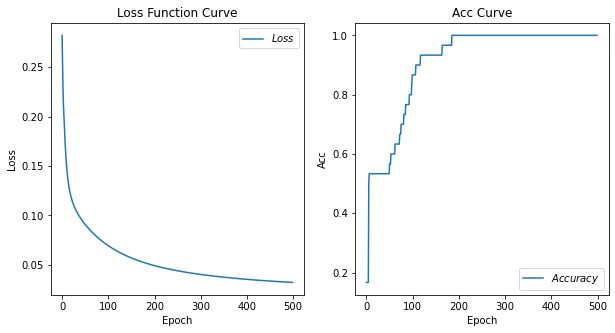

In [13]:
size = 5  # 单张图片大小
plt.figure(figsize=(size*2, size*1))  # 图像窗口

# 绘制 loss 曲线
plt.subplot(1,2,1)
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出train_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标

# 绘制 Accuracy 曲线
plt.subplot(1,2,2)
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()

plt.show()

# 鸢尾花识别 标准模型
六步法搭建神经网络
第一步：import相关模块，如import tensorflow as tf。
第二步：指定输入网络的训练集和测试集，如指定训练集的输入x_train和标签y_train，测试集的输入x_test和标签y_test。
第三步：逐层搭建网络结构，model = models.Sequential()。
第四步：在model.compile()中配置训练方法，选择训练时使用的优化器、损失函数和最终评价指标。
第五步：在model.fit()中执行训练过程，告知训练集和测试集的输入值和标签、每个batch的大小和数据集的迭代次数epoch。
第六步：使用model.summary()打印网络结构，统计参数数目。

## 数据预处理

In [ ]:
# 准备数据
x_train = datasets.load_iris().data
y_train = datasets.load_iris().target

np.random.seed(116)
np.random.shuffle(x_train)
np.random.seed(116)
np.random.shuffle(y_train)
tf.random.set_seed(116)

## 创建模型
用Sequential可以搭建出上层输出就是下层输入的顺序网络结构, 但是无法写出一些带有跳连的非顺序网络结构。这个时候我们可以选择用类class搭建神经网络结构。

In [ ]:
class IrisModel(Model):
    # 继承Model
    def __init__(self):
        super(IrisModel, self).__init__()
        # 定义网络结构块
        self.d1 = Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, x):
        y = self.d1(x)  # 调用网络结构块，实现前向传播
        return y

model = IrisModel()  # 就是把原来的层封装到了类中，与下面等价

Sequential([网络结构]) 容器，封装了一个神经网络结构。
拉直层：layers.Flatten() 这一层不含计算，只是形状转换，把输入特征拉直变成一维数组
全连接层：layers.Dense(神经元个数，activation= "激活函数“，kernel_regularizer=哪种正则化)
    activation(字符串)可选: relu、softmax、sigmoid、tanh
    kernel_regularizer可选: regularizers.l1()、 regularizers.12()
卷积层：layers.Conv2D() 详见卷积神经网络
LSTM层；layers.LSTM()

In [ ]:
# model = models.Sequential()
# model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2()))

## 训练模型

compile配置神经网络的训练方法，告知训练时选择的优化器、损失函数和评测指标
model.compile(optimizer = 优化器, loss = 损失函数, metrics = ["准确率"] )
Optimizer(优化器)可选:
    'sgd' or optimizers.SGD (lr=学习率,momentum=动量参数)
    'adagrad' or optimizers.Adagrad (lr=学习率)
    'adadelta' or optimizers.Adadelta (lr=学习率)
    'adam' or optimizers.Adam (lr=学习率，beta_ 1=0.9, beta_ 2=0.999)
loss是(损失函数)可选:
    'mse' or losses.MeanSquaredError()
    'sparse_categorical_crossentropy' or losses.SparseCategoricalCrossentropy(from_logits=False)
    from_logits参数：是否是原始输出，即没有经概率分布的输出。
        有些神经网络的输出是经过了softmax等函数的概率分布，有些则不经概率分布直接输出，
Metrics(评测指标)可选:
    'accuracy' : y_和y都是数值，如y_=[1] y=[1]
    'categorical_accuracy' : y_和y都是独热码(概率分布)，如y_ =[0,1,0] y=[0 256.0.695,0.048]
    'sparse_categorical_accuracy' : y_是数值，y是独热码(概率分布)，如y_ =[1] y=[0 256,0.695,0.048]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

model.fit(训练集的输入特征，训练集的标签，
        batch_size=每次喂入神经网络的样本数，推荐个数为：2^n
        epochs=要迭代多少次数据集
        validation_data=(测试集的输入特征，测试集的标签),
        validation_split=从训练集划分多少比例给测试集， 和_data二选一
        validation_freq =多少次epoch使用测试集验证一次结果)

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=500, validation_split=0.2, validation_freq=20)
model.summary()  # 打印出网络的结构和参数统计

# 手写数字识别

## 数据预处理

In [ ]:
# 加载数据集 train_images.shape=(60000, 28, 28) test_images.shape=(10000, 28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 正规化：像素在0~255之间，映射到0~1
x_train, x_test = x_train / 255.0, x_test / 255.0

### 自制数据集
即自己写个函数，把mnist.load_data()替换掉，但是同样得到x_train, y_train
手写数字图片都是28*28的像素点，每个像素点都是[0, 255]之间的整数；纯黑色=0 纯白色=255
label.txt 每行都是：
图像名     标签
4_8.jpg    8

In [ ]:
train_path = './mnist_image_label/mnist_train_jpg_60000/'
train_txt = './mnist_image_label/mnist_train_jpg_60000.txt'
x_train_savepath = './mnist_image_label/mnist_x_train.npy'
y_train_savepath = './mnist_image_label/mnist_y_train.npy'

test_path = './mnist_image_label/mnist_test_jpg_10000/'
test_txt = './mnist_image_label/mnist_test_jpg_10000.txt'
x_test_savepath = './mnist_image_label/mnist_x_test.npy'
y_test_savepath = './mnist_image_label/mnist_y_test.npy'

def generateds(path, txt):  # (图片路径，标签文件)
    f = open(txt, 'r')  # 以只读形式打开txt文件
    contents = f.readlines()  # 读取文件中所有行
    f.close()  # 关闭txt文件
    x, y_ = [], []  # 建立空列表
    for content in contents:  # 逐行取出
        value = content.split()  # 以空格分开，图片路径为value[0] , 标签为value[1] , 存入列表
        img_path = path + value[0]  # 拼出图片路径和文件名
        img = Image.open(img_path)  # 读入图片
        img = np.array(img.convert('L'))  # 图片变为8位宽灰度值的np.array格式
        img = img / 255.  # 数据归一化 （实现预处理）
        x.append(img)  # 归一化后的数据，贴到列表x
        y_.append(value[1])  # 标签贴到列表y_
        print('loading : ' + content)  # 打印状态提示

    x = np.array(x)  # 变为np.array格式
    y_ = np.array(y_)  # 变为np.array格式
    y_ = y_.astype(np.int64)  # 变为64位整型
    return x, y_  # 返回输入特征x，返回标签y_

# 判断数据集是否存在，存在直接调用，不存在时调用generateds制作数据集
if os.path.exists(x_train_savepath) and os.path.exists(y_train_savepath) and os.path.exists(
        x_test_savepath) and os.path.exists(y_test_savepath):
    print('-------------Load Datasets-----------------')
    x_train_save = np.load(x_train_savepath)
    y_train = np.load(y_train_savepath)
    x_test_save = np.load(x_test_savepath)
    y_test = np.load(y_test_savepath)
    x_train = np.reshape(x_train_save, (len(x_train_save), 28, 28))
    x_test = np.reshape(x_test_save, (len(x_test_save), 28, 28))
else:
    print('-------------Generate Datasets-----------------')
    x_train, y_train = generateds(train_path, train_txt)
    x_test, y_test = generateds(test_path, test_txt)

    print('-------------Save Datasets-----------------')
    x_train_save = np.reshape(x_train, (len(x_train), -1))
    x_test_save = np.reshape(x_test, (len(x_test), -1))
    np.save(x_train_savepath, x_train_save)
    np.save(y_train_savepath, y_train)
    np.save(x_test_savepath, x_test_save)
    np.save(y_test_savepath, y_test)

# 其他同baseline

### 数据增强

In [ ]:
# 给数据增加一个维度,从(60000, 28, 28)reshape为(60000, 28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

"""
数据增强：对图像的增强就是对图像进行简单形变，解决因为拍照角度不同等因素造成的影响。
image_gen._train = lmageDataGenerator(
	rescale =所有数据将乘以该数值
	rotation_ range =随机旋转角度数范围
	width_ shift range =随机宽度偏移量
	height shift range =随机高度偏移量
	水平翻转: horizontal_flip =是否随机水平翻转
	随机缩放: zoom_range =随机缩放的范围[1-n, 1+n] )
"""
image_gen_train = ImageDataGenerator(
    rescale=1. / 1.,  # 如为图像，分母为255时，可归至0～1
    rotation_range=45,  # 随机45度旋转
    width_shift_range=.15,  # 宽度偏移
    height_shift_range=.15,  # 高度偏移
    horizontal_flip=False,  # 水平翻转
    zoom_range=0.5  # 将图像随机缩放阈量50％
)
image_gen_train.fit(x_train)

# model.fit(image_gen_train.flow(x_train, y_train, batch_size=32),...  # 数据增强

## 创建模型

In [ ]:
class MnistModel(Model):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.flatten = layers.Flatten()  # 第二维展平 784个元素组成的一维数组
        self.d1 = layers.Dense(128, activation='relu')
        self.d2 = layers.Dense(10, activation='softmax')  # 多分类问题

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        y = self.d2(x)
        return y

model = MnistModel()

### 断点续训，存取模型
load_weights(路径文件名)
1 定义存放模型的路径和文件名，命名为ckpt文件
2 生成ckpt文件时会同步生成index索引表，所以判断索引表是否存在，来判断是否存在模型参数
3 如有索引表，则直接读取ckpt文件中的模型参数

In [ ]:
checkpoint_save_path = "./checkpoint/mnist.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                        save_weights_only=True,
                                        save_best_only=True)
model.fit(x_train, y_train,  epochs=5,
          validation_data=(x_test, y_test), validation_freq=1,
          callbacks=[cp_callback])  # 保存模型

## 设置损失函数和优化器

In [ ]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

## 训练模型

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5,
                    validation_data=(x_test, y_test), validation_freq=1)

model.summary()

### 参数提取：把参数存入文本
model.trainable_variables：返回模型中可训练的参数

In [ ]:
np.set_printoptions(threshold=np.inf)  # (threshold=超过多少省略显示)  inf表示无限大
print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

## acc loss 可视化
history=model.fit(训练集数据，训练集标签，batch_size=, epochs=,
    validation_split=用作测试数据的比例,validation_ data=测试集，
    validation_freq=测试频率
    训练集loss: loss
    测试集loss: val_loss
    训练集准确率: sparse_categorical_accuracy
    测试集准确率: val_sparse_categorical_accuracy)

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplots_adjust(hspace=0.5)  # 调整子图间距

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()